In [ ]:
import pandas as pd
import numpy as np
import spacy
from spacy.lang.es.stop_words import STOP_WORDS

import string
import re
import sys
import unicodedata
import glob

# Visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Importar librerías de aprendizaje
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


# Librerías de predicción
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

# Evaluación del modelo
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score

# Setting Jupyter outputs

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',200)
pd.options.display.float_format= '{:.2f}'.format

# Ignorar Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
nlp = spacy.load('es_core_news_sm')

In [3]:
path = '../../data/corpus'
all_files = glob.glob(path + "/*.tsv")

In [4]:
li_mapper = map(lambda filename: pd.read_table(filename,index_col=None,header=None,sep="\t"), all_files)
li_2 = list(li_mapper)

In [5]:
df = pd.concat(li_2,axis=0,ignore_index=True)
columns= ['ID','Texto','Sentimiento']
df.columns=columns
df.head()

,ID,Texto,Sentimiento
0,819337926026862593,Antojo de empanada colombiana,NEU
1,817464156756574208,Me volvieron a dejar sola,N
2,819237267181080576,@ManuTonic Buenotes diotas. Un gran abrazo,P
3,817486639681466371,cual es su mejor recuerdo juntos? #BntResponde,NEU
4,819406610636357632,"@leonora_monge @susi_sot por mi sí, con 20 rojos",NEU


In [47]:
print(f'el conjunto de datos tiene {df.shape[0]} filas y {df.shape[1]} columnas')

el conjunto de datos tiene 4929 filas y 3 columnas


In [7]:
def limpieza_texto(texto):
    #Se reemplazan los caracteres unicode, no se dejaron tildes porque causan error
    caracteres = dict.fromkeys(c for c in range(sys.maxunicode) if unicodedata.combining(chr(c)))
    cadena_normalizada = unicodedata.normalize('NFD',texto)
    texto = cadena_normalizada.translate(caracteres)
    #Eliminar las menciones a otros usuarios de twitter
    texto = re.sub('@[\S]*', '', texto) #Eliminar menciones (@)
    texto = re.sub('@[A-Za-z0–9]+', '', texto) # Eliminar "#" del texto
    #eliminación de signos de puntuación y mayúsculas
    texto = re.sub('[¡!#$).;¿?&°]', '', texto.lower())
    return texto

In [8]:
def cambio_valores(df,valor):
    indexNames = df[(df[valor] == 'none') | (df[valor] == 'NEU')].index
    df.drop(indexNames , inplace=True)
    df[valor]= df[valor].str.replace('P','1')
    df[valor] = df[valor].str.replace('N','0')
    df[valor] = df[valor].astype(int)

In [9]:
df['Texto'] = df['Texto'].apply(limpieza_texto)

In [10]:
df['Texto']

0                           antojo de empanada colombiana
1                               me volvieron a dejar sola
2                          buenotes diotas un gran abrazo
3            cual es su mejor recuerdo juntos bntresponde
4                                 por mi si, con 20 rojos
                              ...                        
7240    que tipo de proyecto de diseno es tu preferido...
7241    que bueno ver a personas que te alegran aunque...
7242     gracias queridisimo  buenisimos la charla la ...
7243     pero antes si era asi es parte de nuestro bar...
7244     compre "hasta borinquen" por internet a ver s...
Name: Texto, Length: 7245, dtype: object

In [11]:
cambio_valores(df,'Sentimiento')

In [13]:
#Verificar si hay datos nulos
df.isnull().sum()

ID             0
Texto          0
Sentimiento    0
dtype: int64

## Tokenización

In [14]:
stopwords_spacy = list(STOP_WORDS)

#Constante de signos de puntuación (para referencia pues se eliminaron en el archivo fuente)

puntuacion = string.punctuation + '¡¿'
puntuacion

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~¡¿'

In [15]:
#Función para limpieza de datos
def text_data_cleaning(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.strip()
        else:
            temp = token
        tokens.append(temp)
    
    clean_tokens = []
    for token in tokens:
        if token not in stopwords_spacy and token not in puntuacion:
            clean_tokens.append(token)
    
    return clean_tokens

In [16]:
text_data_cleaning("¡Hola cómo estás!. ¿Te gustaría tomar una taza de café?")

['Hola', 'gustar', 'tomar', 'taza', 'café']

Sentimiento
0    2836
1    2093
dtype: int64
Total of records 4929


La porporción de "Negativo" es: 57.54 %
the proportion of "Positivo" is: 42.46 %





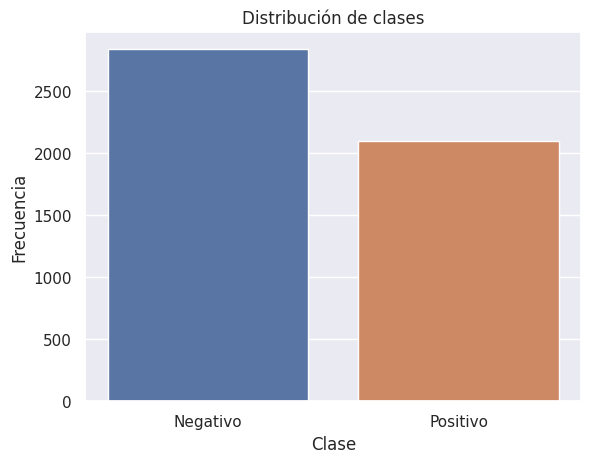

In [17]:
class_counts = df.groupby('Sentimiento').size()
print(class_counts)
print('Total of records',len(df))
print('\n')
print('La porporción de "Negativo" es:',round(class_counts[0]/len(df)*100,2),'%')
print('the proportion of "Positivo" is:',round(class_counts[1]/len(df)*100,2),'%')
print('\n'*2)
nombres = ["Negativo", "Positivo"]
contar_clases = sns.countplot(df['Sentimiento'])
contar_clases.plot(kind = 'bar', rot=0)
plt.title("Distribución de clases")
plt.xticks(range(2), nombres)
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

# Vectorization Feature Engineering (TF-IDF)

In [18]:
#Definir la función de tokenizado y crear el clasificador
tfidf = TfidfVectorizer(tokenizer = text_data_cleaning)
classifier = LinearSVC(loss='hinge',penalty='l2',random_state=42,max_iter=2500)
classifier2 = LogisticRegression(penalty='elasticnet',tol=1e-3,fit_intercept=1,random_state=42,solver='saga',max_iter=500,l1_ratio=0)
classifier3=SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=500, tol=1e-2)

In [19]:
#Crear los vectores de datos
X = df['Texto']
y = df['Sentimiento']

In [20]:
#Crear el vector de entrenamiento como una porción de los datos y dejar el resto para pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]

(3943, 986, 3943, 986)

In [21]:
#Crear un pipeline
clf = Pipeline([('tfidf', tfidf), ('clf', classifier)])
clf2= Pipeline([('tfidf', tfidf), ('clf', classifier2)])
clf3= Pipeline([('tfidf', tfidf), ('clf', classifier3)])

In [22]:
#Entrenar el clasificador
clf.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning at 0x7f5109881700>)),
                ('clf',
                 LinearSVC(loss='hinge', max_iter=2500, random_state=42))])

In [23]:
clf2.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning at 0x7f5109881700>)),
                ('clf',
                 LogisticRegression(fit_intercept=1, l1_ratio=0, max_iter=500,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga', tol=0.001))])

In [24]:
clf3.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning at 0x7f5109881700>)),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=500, random_state=42,
                               tol=0.01))])

In [25]:
predictions = clf.predict(X_test)
predictions2 = clf2.predict(X_test)
predictions3 = clf3.predict(X_test)

In [26]:
#Crear el vectos de valores predichos a partir del clasificador
y_pred = clf.predict(X_test)
y_pred2 = clf2.predict(X_test)
y_pred3 = clf3.predict(X_test)

In [27]:
# Ver la precisión obtenida
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       581
           1       0.76      0.60      0.67       405

    accuracy                           0.76       986
   macro avg       0.76      0.73      0.74       986
weighted avg       0.76      0.76      0.75       986



In [28]:
#Ver la precisión obtenida
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81       581
           1       0.79      0.56      0.65       405

    accuracy                           0.76       986
   macro avg       0.76      0.73      0.73       986
weighted avg       0.76      0.76      0.75       986



In [29]:
#Ver la precisión obtenida
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.69      0.97      0.81       581
           1       0.91      0.36      0.52       405

    accuracy                           0.72       986
   macro avg       0.80      0.67      0.66       986
weighted avg       0.78      0.72      0.69       986



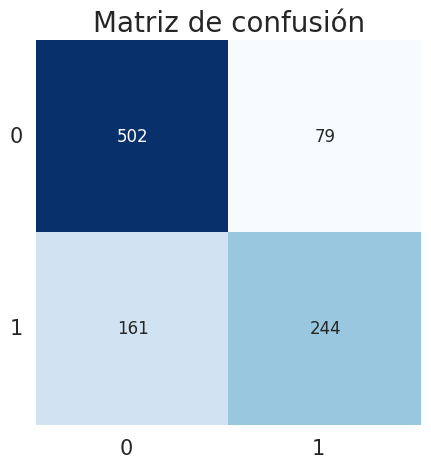

In [30]:
#Obtención de la matriz
arrayRF = confusion_matrix(y_test, y_pred)
df_cmRF = pd.DataFrame(arrayRF)

#Representación de la matriz de confusión
f, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(df_cmRF, 
                    square=True,
                    cmap="Blues",
                    annot=True,
                    fmt="d",
                    cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right',fontsize = 15)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right',fontsize = 15)
plt.title('Matriz de confusión',fontsize = 20)
plt.show()

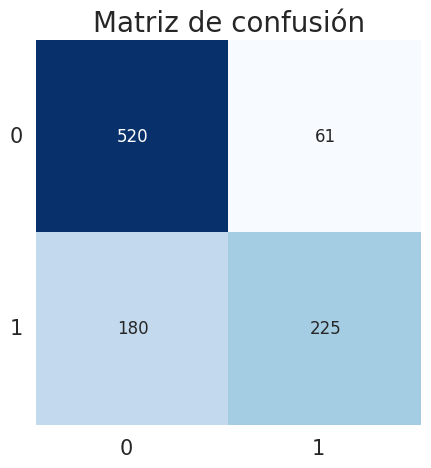

In [31]:
#Obtención de la matriz
arrayRF = confusion_matrix(y_test, y_pred2)
df_cmRF = pd.DataFrame(arrayRF)

#Representación de la matriz de confusión
f, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(df_cmRF, 
                    square=True,
                    cmap="Blues",
                    annot=True,
                    fmt="d",
                    cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right',fontsize = 15)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right',fontsize = 15)
plt.title('Matriz de confusión',fontsize = 20)
plt.show()

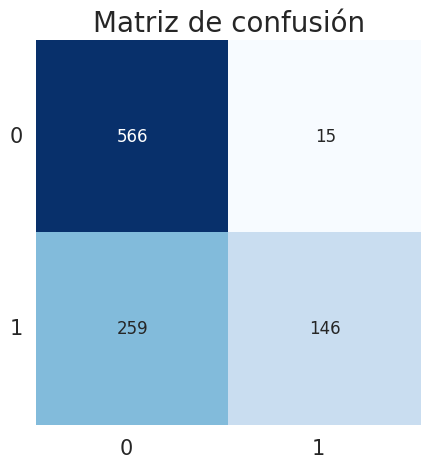

In [32]:
#Obtención de la matriz
arrayRF = confusion_matrix(y_test, y_pred3)
df_cmRF = pd.DataFrame(arrayRF)

#Representación de la matriz de confusión
f, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(df_cmRF, 
                    square=True,
                    cmap="Blues",
                    annot=True,
                    fmt="d",
                    cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right',fontsize = 15)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right',fontsize = 15)
plt.title('Matriz de confusión',fontsize = 20)
plt.show()

In [33]:
print("TfidfVectorizer -> ", "Accuracy: ", round(accuracy_score(y_test, y_pred),2), "Precision: ", round(precision_score(y_test, y_pred),2), "Recall: ", round(recall_score(y_test, y_pred),2))
print()
print("Linear SVC -> ", "Accuracy: ", round(accuracy_score(y_test, y_pred),2), "Precision: ", round(precision_score(y_test, y_pred),2), "Recall: ", round(recall_score(y_test, y_pred),2))
print()
print("Logistic Regression -> ", "Accuracy: ", round(accuracy_score(y_test, y_pred),2), "Precision: ", round(precision_score(y_test, y_pred),2), "Recall: ", round(recall_score(y_test, y_pred),2))

TfidfVectorizer ->  Accuracy:  0.76 Precision:  0.76 Recall:  0.6

Linear SVC ->  Accuracy:  0.76 Precision:  0.76 Recall:  0.6

Logistic Regression ->  Accuracy:  0.76 Precision:  0.76 Recall:  0.6


In [34]:
# Traer el nuevo dataset
tweets=pd.read_csv('../../data/data_modelo/Texto.csv')
tweets.head()

,Texto
0,Te ganarás la vacuna con el sudor de tu frente...
1,"""Además, al momento, constató que sólo falleci..."
2,Después de la vacuna contra covid aconsejan no...
3,QUE EL MUNDO SEPA QUIENES SON UDS. LACRASSer f...
4,Ser funcionario te protege más contra el COVI...


In [35]:
tweets['Texto'] = tweets['Texto'].apply(limpieza_texto)

In [36]:
tweets['Texto'].shape

(2599,)

In [37]:
validation = tweets['Texto']

predictions = clf.predict(validation)

tweets['sentimiento']=predictions


In [38]:
tweets['sentimiento']=tweets['sentimiento'].replace(0,'Negativo')
tweets['sentimiento']=tweets['sentimiento'].replace(1,'Positivo')

In [40]:
tweets.head()

,Texto,sentimiento
0,te ganaras la vacuna con el sudor de tu frente...,Negativo
1,"""ademas, al momento, constato que solo falleci...",Negativo
2,despues de la vacuna contra covid aconsejan no...,Negativo
3,que el mundo sepa quienes son uds lacrasser fu...,Positivo
4,ser funcionario te protege mas contra el covi...,Positivo


In [41]:
tweets.to_csv('../../data/data_procesada/model_process.csv',index=False)